<a href="https://colab.research.google.com/github/Druvith/NN_from_scratch2023/blob/main/Resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install d2l==1.0.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.7/111.7 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 62.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 113.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.9/121.9 kB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.3/98.3 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 kB 33.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.4/93.4 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 83.2 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.11.3
    Uninstalling scipy-1.11.3:
      Successfully uninstalled scipy-1.11.3
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 3.1.1
    Uninstalling pyparsing-3.1.1:
     

In [2]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

In [10]:
class Residual(nn.Module):
    """The Residual block of ResNet models."""
    def __init__(self, num_channels, use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1,
                                   stride=strides)
        self.conv2 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.LazyConv2d(num_channels, kernel_size=1,
                                       stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.LazyBatchNorm2d()
        self.bn2 = nn.LazyBatchNorm2d()

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

In [11]:
blk = Residual(3)
X = torch.randn(4, 3, 6, 6)
blk(X).shape

torch.Size([4, 3, 6, 6])

In [12]:
blk = Residual(6, use_1x1conv=True, strides=2)
blk(X).shape

torch.Size([4, 6, 3, 3])

In [13]:
class ResNet(d2l.Classifier):
  def b1(self):
    return nn.Sequential(
        nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3),
        nn.LazyBatchNorm2d(), nn.ReLU(),
        nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
    )

In [14]:
@d2l.add_to_class(ResNet)
def block(self, num_residuals, num_channels, first_block = False):
  blk = []
  for i in range(num_residuals):
    if i == 0 and not first_block:
      blk.append(Residual(num_channels, use_1x1conv=True, strides=2))
    else:
      blk.append(Residual(num_channels))
  return nn.Sequential(*blk)


In [18]:
@d2l.add_to_class(ResNet)
def __init__(self, arch, lr = 0.01, num_classes=10):
  super(ResNet, self).__init__()
  self.save_hyperparameters()
  self.net = nn.Sequential(self.b1())
  for i, b in enumerate(arch):
    self.net.add_module('last', nn.Sequential(
        nn.AdaptiveAvgPool2d((1,1)), nn.Flatten(),
        nn.LazyLinear(num_classes)
    ))
    self.net.apply(d2l.init_cnn)

In [19]:
class ResNet18(ResNet):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__(((2, 64), (2, 128), (2, 256), (2, 512)),
                       lr, num_classes)

ResNet18().layer_summary((1, 1, 96, 96))

Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 10])


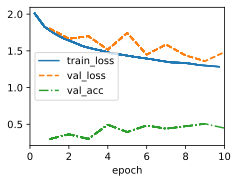

In [20]:
model = ResNet18(lr=0.01)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(96, 96))
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
trainer.fit(model, data)

In [14]:
class Residual(nn.Module):  #@save
    """The Residual block of ResNet models."""
    def __init__(self, num_channels, use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1,
                                   stride=strides)
        self.conv2 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.LazyConv2d(num_channels, kernel_size=1,
                                       stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.LazyBatchNorm2d()
        self.bn2 = nn.LazyBatchNorm2d()

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

In [15]:
class ResNet(d2l.Classifier):
  def b1(self):
    return nn.Sequential(
        nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3),
        nn.LazyBatchNorm2d(), nn.ReLU(),
        nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
    )

In [16]:
@d2l.add_to_class(ResNet)
def block(self, num_residuals, num_channels, first_block=False):
  blk = []
  for i in range(num_residuals):
    if i == 0  and not first_block:
      blk.append(Residual(num_channels, use_1x1conv=True, strides=2))
    else:
      blk.append(Residual(num_channels))
  return nn.Sequential(*blk)

In [17]:
@d2l.add_to_class(ResNet)
def __init__(self, arch, lr=0.1, num_classes=10):
    super(ResNet, self).__init__()
    self.save_hyperparameters()
    self.net = nn.Sequential(self.b1())
    for i, b in enumerate(arch):
        self.net.add_module(f'b{i+2}', self.block(*b, first_block=(i==0)))
    self.net.add_module('last', nn.Sequential(
        nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(),
        nn.LazyLinear(num_classes)))
    self.net.apply(d2l.init_cnn)

In [18]:
class ResNet18(ResNet):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__(((2, 64), (2, 128), (2, 256), (2, 512)),
                       lr, num_classes)

ResNet18().layer_summary((1, 1, 96, 96))

Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 128, 12, 12])
Sequential output shape:	 torch.Size([1, 256, 6, 6])
Sequential output shape:	 torch.Size([1, 512, 3, 3])
Sequential output shape:	 torch.Size([1, 10])


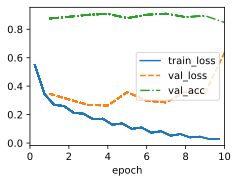

In [19]:
model = ResNet18(lr=0.01)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(96,96))
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
trainer.fit(model, data)

In [20]:
#Grouped Convolution (ResNetXt)


In [21]:
class ResNeXtBlock(nn.Module):
    """The ResNeXt block."""
    def __init__(self, num_channels, groups, bot_mul, use_1x1conv=False,
                 strides=1):
        super().__init__()
        bot_channels = int(round(num_channels * bot_mul))
        self.conv1 = nn.LazyConv2d(bot_channels, kernel_size=1, stride=1)
        self.conv2 = nn.LazyConv2d(bot_channels, kernel_size=3,
                                   stride=strides, padding=1,
                                   groups=bot_channels//groups)
        self.conv3 = nn.LazyConv2d(num_channels, kernel_size=1, stride=1)
        self.bn1 = nn.LazyBatchNorm2d()
        self.bn2 = nn.LazyBatchNorm2d()
        self.bn3 = nn.LazyBatchNorm2d()
        if use_1x1conv:
            self.conv4 = nn.LazyConv2d(num_channels, kernel_size=1,
                                       stride=strides)
            self.bn4 = nn.LazyBatchNorm2d()
        else:
            self.conv4 = None

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = F.relu(self.bn2(self.conv2(Y)))
        Y = self.bn3(self.conv3(Y))
        if self.conv4:
            X = self.bn4(self.conv4(X))
        return F.relu(Y + X)

In [2]:
#Dense Net architecture

In [3]:
import torch
from torch import nn
from d2l import torch as d2l

In [4]:
def conv_block(num_channels):
  return nn.Sequential(
      nn.LazyBatchNorm2d(), nn.ReLU(),
      nn.LazyConv2d(num_channels, kernel_size=3, padding=1))


In [5]:
class DenseBlock(nn.Module):
  def __init__(self, num_convs, num_channels):
    super(DenseBlock, self).__init__()
    layer=[]
    for i in range(num_convs):
      layer.append(conv_block(num_channels))
    self.net = nn.Sequential(*layer)

  def forward(self, X):
    for blk in self.net:
      Y = blk(X)
      X = torch.cat((X, Y), dim=1)
    return X

In [6]:
blk = DenseBlock(2, 10)
X = torch.randn(4, 3, 8, 8)
Y = blk(X)
Y.shape

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


torch.Size([4, 23, 8, 8])

In [7]:
def transition_block(num_channels):
  return nn.Sequential(
      nn.LazyBatchNorm2d(), nn.ReLU(),
      nn.LazyConv2d(num_channels, kernel_size=1),
      nn.AvgPool2d(kernel_size=2, stride=2)
  )

In [8]:
blk = transition_block(10)
blk(Y).shape

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


torch.Size([4, 10, 4, 4])

In [15]:
class DenseNet(d2l.Classifier):
  def b1(self):
    return nn.Sequential(
        nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3),
        nn.LazyBatchNorm2d(), nn.ReLU(),
        nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
    )

In [16]:
@d2l.add_to_class(DenseNet)
def __init__(self, num_channels=64, growth_rate=32, arch=(4, 4, 4, 4),
             lr=0.1, num_classes=10):
    super(DenseNet, self).__init__()
    self.save_hyperparameters()
    self.net = nn.Sequential(self.b1())
    for i, num_convs in enumerate(arch):
        self.net.add_module(f'dense_blk{i+1}', DenseBlock(num_convs,
                                                          growth_rate))
        # The number of output channels in the previous dense block
        num_channels += num_convs * growth_rate
        # A transition layer that halves the number of channels is added
        # between the dense blocks
        if i != len(arch) - 1:
            num_channels //= 2
            self.net.add_module(f'tran_blk{i+1}', transition_block(
                num_channels))
    self.net.add_module('last', nn.Sequential(
        nn.LazyBatchNorm2d(), nn.ReLU(),
        nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(),
        nn.LazyLinear(num_classes)))
    self.net.apply(d2l.init_cnn)

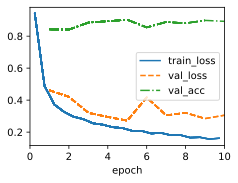

In [17]:
model = DenseNet(lr=0.01)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(96, 96))
trainer.fit(model, data)

In [2]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

In [3]:
class AnyNet(d2l.Classifier):
  def stem(self, num_channels):
    return nn.Sequential(
        nn.LazyConv2d(num_channels, kernel_size=3, stride=2, padding=1),
        nn.LazyBatchNorm2d(), nn.ReLU()
    )

In [5]:
@d2l.add_to_class(AnyNet)
def stage(self, depth, num_channels, groups, bot_mul):
  blk = []
  for i in range(depth):
    if i == 0:
      blk.append(d2l.ResNeXtBlock(num_channels, groups,bot_mul, use_1x1conv=True, strides=2))
    else:
      blk.append(d2l.ResNeXtBlock(num_channels, groups, bot_mul))
  return nn.Sequential(*blk)

In [6]:
@d2l.add_to_class(AnyNet)
def __init__(self, arch, stem_channels, lr=0.1, num_classes=10):
  super(AnyNet, self).__init__()
  self.save_hyperparameters()
  self.net = nn.Sequential(self.stem(stem_channels))
  for i, s in enumerate(arch):
    self.net.add_module(f'stage{i+1}', self.stage(*s))
  self.net.add_module('head', nn.Sequential(
      nn.AdaptiveAvgPool2d((1,1)), nn.Flatten(),
      nn.LazyLinear(num_classes)))
  self.net.apply(d2l.init_cnn)


In [7]:
class RegNetX32(AnyNet):
    def __init__(self, lr=0.1, num_classes=10):
        stem_channels, groups, bot_mul = 32, 16, 1
        depths, channels = (4, 6), (32, 80)
        super().__init__(
            ((depths[0], channels[0], groups, bot_mul),
             (depths[1], channels[1], groups, bot_mul)),
            stem_channels, lr, num_classes)

In [8]:
RegNetX32().layer_summary((1, 1, 96, 96))

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Sequential output shape:	 torch.Size([1, 32, 48, 48])
Sequential output shape:	 torch.Size([1, 32, 24, 24])
Sequential output shape:	 torch.Size([1, 80, 12, 12])
Sequential output shape:	 torch.Size([1, 10])


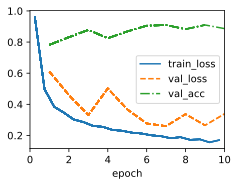

In [9]:
model = RegNetX32(lr=0.05)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(96, 96))
trainer.fit(model, data)